In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import seaborn as sns
import scipy.ndimage as ndimage
from scipy.ndimage import center_of_mass
import glob
import corner
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{bm}'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import os

In [2]:
data = fits.open('Rommulus_withLight_Mock_i2_SNIa_z1_cusp.fits')
data.info()

Filename: Rommulus_withLight_Mock_i2_SNIa_z1_cusp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (1039, 1039, 6)   float64   


In [3]:
data[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1039                                                  
NAXIS2  =                 1039                                                  
NAXIS3  =                    6                                                  
EXTEND  =                    T                                                  
BUNIT   = 'electron/s'                                                          
TELESCOP= 'HST     '                                                            
INSTRUME= 'WFC3    '                                                            
FILTER  = 'SDSS-r (F625W)'                                                      
PHOTFLAM=              1.2E-19 / erg/cm**2/AA/electron                          
WL_PIVOT=               6266

In [4]:
gal = data[0].data[2] # Index 2 because cube_3 is the post snIa image of just the galaxy
noise = data[0].data[3] # Index 3 because cube_4 is the noisemap of cube_3

In [5]:
def get_Pos_1stGuess(mock_lens_data):
    image = mock_lens_data

    # Apply Gaussian Filter to Denoise
    smoothed_image = image # No smoothing this time #ndimage.gaussian_filter(image, sigma=2)

    # Find Local Maxima
    threshold = np.std(image)*10  # 5 sig above noise
    local_max = (smoothed_image == ndimage.maximum_filter(smoothed_image, size=5)) & (smoothed_image > threshold)

    # Get Peak Coordinates
    peaks = np.argwhere(local_max)
    imgs_x , imgs_y = peaks[:, 1], peaks[:, 0]
    imgs_x , imgs_y = np.asarray(imgs_x) , np.asarray(imgs_y)
    imgs_x , imgs_y = imgs_x+1 , imgs_y+1
    return imgs_x , imgs_y

In [6]:
# Approximate centre of the galaxy
imgs_x , imgs_y = get_Pos_1stGuess(gal)
print(imgs_x , imgs_y)

[522] [521]


(481.0, 561.0)

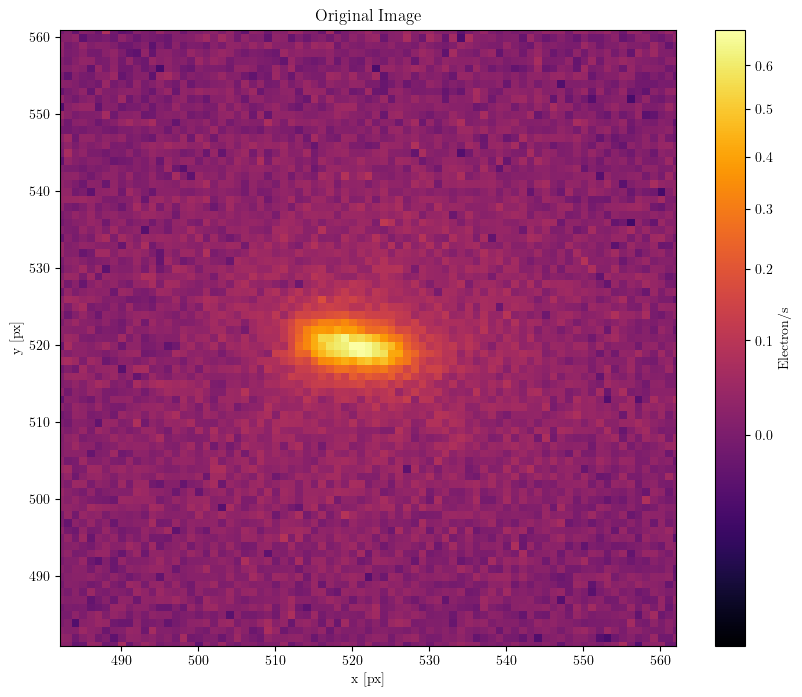

In [7]:
norm = ImageNormalize(stretch=SqrtStretch())

zoom = 40
plt.figure(figsize=(10,8))
plt.imshow(gal, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)

In [8]:
def saveFITS(image,Header,SavePath,FileName):
    hdu0 = fits.PrimaryHDU(image)
    #hdu_new = fits.HDUList([hdu0])
    hdu0.writeto(SavePath+FileName+'.fits',image, overwrite=True)
    return

def saveFITS_simple(image,SavePath,FileName):
    hdu0 = fits.PrimaryHDU(image)
    hdu_new = fits.HDUList([hdu0])
    hdu_new.writeto(SavePath+FileName+'.fits', overwrite=True)
    return

def create_mask_circle(x,y,image,Radius=5):
    X = np.linspace(0,image.shape[1]-1,image.shape[1])
    Y = np.linspace(0,image.shape[0]-1,image.shape[0])
    
    XX,YY = np.meshgrid(X-x,Y-y)
    RR = (XX**2 + YY**2)**0.5

    mask = np.zeros(image.shape)
    mask = np.int64(np.where(RR>Radius,1,mask))
    return mask

In [23]:
# Sersic Function
def write_imfit_config_str(img_x , img_y , image):
    string = ''
    string += 'X0' + '\t' + str(img_x) + '\t' + str(518) + ',' + str(522) + '\n'
    string += 'Y0' + '\t' + str(img_y) + '\t' + str(518) + ',' + str(522) + '\n'
    string += 'FUNCTION Sersic' + '\n'
    string += 'PA' + '\t' + str(82.4567) + '\t' + str(78) + ',' + str(84) + '\n'
    string += 'ell' + '\t' + str(0.708713) + '\t' + str(0.2) + ',' + str(1.0) + '\n'
    string += 'n' + '\t' + str(1.0) + '\t' + str(0.1) + ',' + str(4.0) + '\n'
    string += 'I_e' + '\t' + str(0.1) + '\t' + str(0.01) + ',' + str(0.8) + '\n'
    string += 'r_e' + '\t' + str(11.74229) + '\t' + str(8) + ',' + str(15) + '\n'
    return string

def write_imfit_config_str(img_x , img_y , image):
    string = ''
    string += 'X0' + '\t' + str(521.3414) + '\n'
    string += 'Y0' + '\t' + str(520.8546) + '\n'
    string += 'FUNCTION Sersic' + '\n'
    string += 'PA' + '\t' + str(82.4567) + '\n'
    string += 'ell' + '\t' + str(0.708713) + '\n'
    string += 'n' + '\t' + str(1.0) + '\n' # Sersic index
    string += 'I_e' + '\t' + str(0.1) + ' \n' # Surface brightness at the effective radius
    string += 'r_e' + '\t' + str(11.74229) + ' \n' # Effective radius
    return string

# # Gaussian function
# def write_imfit_config_str(img_x , img_y , image):
#     string = ''
#     string += 'X0' + '\t' + str(img_x) + '\n'
#     string += 'Y0' + '\t' + str(img_y) + '\n'
#     string += 'FUNCTION Gaussian' + '\n'
#     string += 'PA' + '\t' + str(90) + '\n'
#     string += 'ell' + '\t' + str(0.01) + '\n'
#     string += 'I_0' + '\t' + str(0.1) + '\n'
#     string += 'sigma' + '\t' + str(0.02) + ' \n'
#     return string


def save_imfit_config(config_str,output_FilePath):
    with open(output_FilePath, "w") as text_file:
        text_file.write(config_str)
    return 

In [24]:
main_folder_path = ''
sub_folder_path = ''

# Create a folder to store the fitting results
folder4imfitfiles = main_folder_path+sub_folder_path+'lensing_galaxy'
if os.path.exists(folder4imfitfiles) == False:
    os.mkdir(folder4imfitfiles)
if os.path.exists(folder4imfitfiles+'/imfit_ImgPos') == False:
    os.mkdir(folder4imfitfiles+'/imfit_ImgPos')
    
folder4imfitfiles

'lensing_galaxy'

In [25]:
mock_lens_data = gal
# Save a copy of the mock img and it's noisemap
# saveFITS_simple(mock_lens_data,folder4imfitfiles+'/imfit_ImgPos/','mock_obs')
# saveFITS_simple(data[0].data[3],folder4imfitfiles+'/imfit_ImgPos/','mock_obs_noisemap')

# Path to imfit program
imfit_PATH = '/usr/local/bin/'

# Run imfit 
for i in range(len(imgs_x)):
    # Create and save the masking map
    mask = create_mask_circle(imgs_x[i],imgs_y[i],mock_lens_data,Radius=40)
    saveFITS_simple(np.int8(mask),folder4imfitfiles+'/imfit_ImgPos/','mask_img_'+str(i+1))
    # Create and save the config file
    text = write_imfit_config_str(imgs_x[i] , imgs_y[i] , mock_lens_data)
    config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'config_img_'+str(i+1)+'.txt'
    save_imfit_config(text,config_output_FilePath)
    # Print the command for running imfit
    imfit_cmd = (imfit_PATH+'./imfit ' +
                 folder4imfitfiles+'/imfit_ImgPos/mock_obs.fits' +
                 ' -mask ' + folder4imfitfiles+'/imfit_ImgPos/mask_img_'+str(i+1)+'.fits' + 
                ' -noise ' + folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits' + 
                ' -c ' + config_output_FilePath + 
                ' --save-params ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt' + 
                ' --save-residual ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_res.fits' )
    os.system(imfit_cmd)

	Image file = lensing_galaxy/imfit_ImgPos/mock_obs.fits
	configuration file = lensing_galaxy/imfit_ImgPos/config_img_1.txt
	noise image = lensing_galaxy/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = lensing_galaxy/imfit_ImgPos/mask_img_1.fits
	output residual (data - best-fit model) image = lensing_galaxy/imfit_ImgPos/Pos_Img_1_res.fits
	output best-fit parameter file = lensing_galaxy/imfit_ImgPos/Pos_Img_1_result.txt
Reading data image ("lensing_galaxy/imfit_ImgPos/mock_obs.fits") ...
naxis1 [# pixels/row] = 1039, naxis2 [# pixels/col] = 1039; nPixels_tot = 1079521
Reading mask image ("lensing_galaxy/imfit_ImgPos/mask_img_1.fits") ...
Reading noise image ("lensing_galaxy/imfit_ImgPos/mock_obs_noisemap.fits") ...
* No PSF image supplied -- no image convolution will be done!
ModelObject::AddMaskVector -- treating zero-valued pixels as good ...
Function: Sersic
7 total parameters
Model Object: 1079521 data values (pixels)
ModelObject: mask vector applied to weight vector. (5025 valid

(481.0, 561.0)

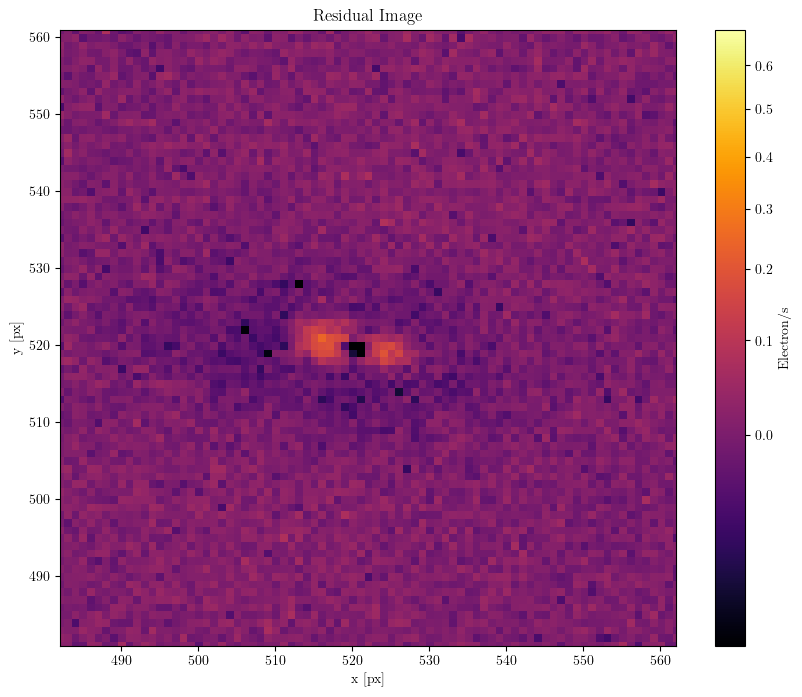

In [26]:
plt.figure(figsize=(10,8))
plt.imshow(fits.open(folder4imfitfiles+'/imfit_ImgPos/Pos_Img_1_res.fits')[0].data, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Residual Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)

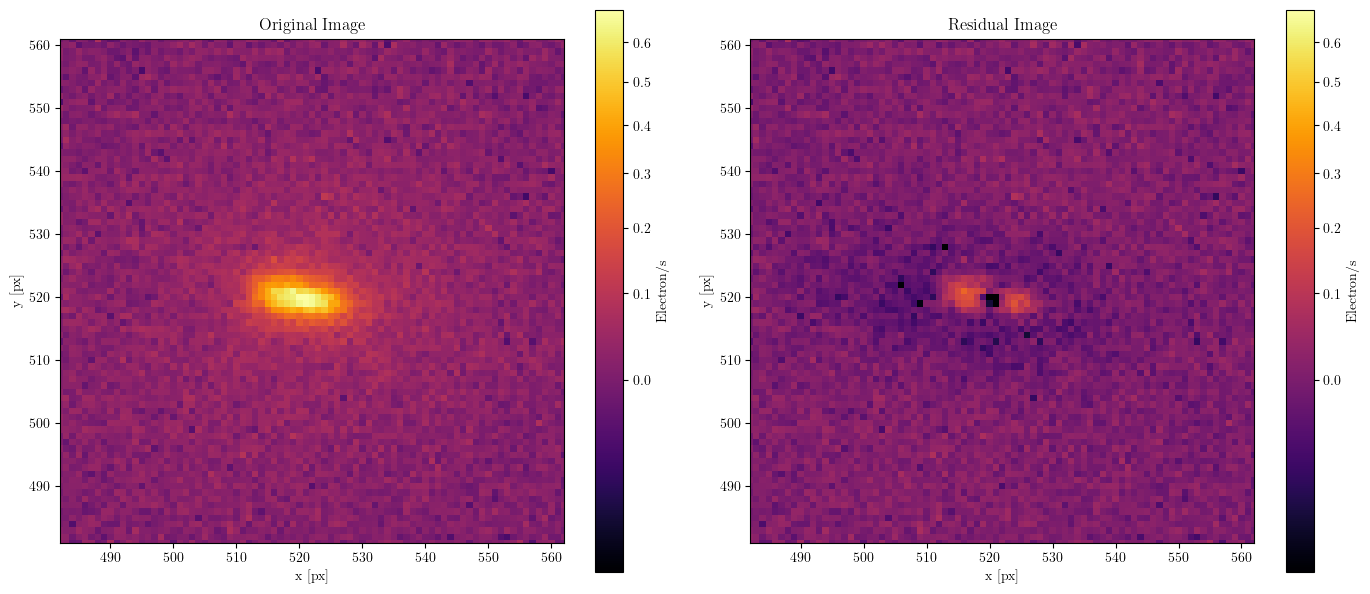

In [28]:
# Plot original image
plt.figure(figsize=(14,6))
norm = ImageNormalize(stretch=SqrtStretch())

plt.subplot(121)
plt.imshow(gal, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)

# Plot the residual image
plt.subplot(122)
plt.imshow(fits.open(folder4imfitfiles+'/imfit_ImgPos/Pos_Img_1_res.fits')[0].data, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Residual Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)

plt.tight_layout()

In [29]:
################################################################
####################    Perform MCMC    ########################
################################################################
#i = 1
for i in range(len(imgs_x)):
    imfit_Bestfit_Path = folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt'
    imfit_Bestfit = pd.read_csv(imfit_Bestfit_Path,comment='#',header=None,sep='\t')

    mcmc_config_text = ''
    for j in range(imfit_Bestfit.shape[0]):
        bestfit_para = imfit_Bestfit[2][j]
        para_name = imfit_Bestfit[0][j]
        if para_name in ['X0','Y0']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1/20) + ',' + str(bestfit_para+1/20) + '\n'
        elif para_name in ['FUNCTION Sersic']:
            mcmc_config_text += para_name + '\n'
        elif para_name in ['PA']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-3) + ',' + str(bestfit_para+3) + '\n'
        elif para_name in ['ell']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-0.1) + ',' + str(bestfit_para+0.1) + '\n'
        elif para_name in ['n']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-0.3) + ',' + str(bestfit_para+0.3) + '\n'
        elif para_name in ['I_e']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-0.1) + ',' + str(bestfit_para+0.1) + '\n'
        elif para_name in ['r_e']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1) + ',' + str(bestfit_para+1) + '\n'

    mcmc_config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'config_mcmc_img_'+str(i+1)+'.txt'
    save_imfit_config(mcmc_config_text,mcmc_config_output_FilePath)

    imfit_mcmc_cmd = (imfit_PATH+'./imfit-mcmc ' +
                     folder4imfitfiles+'/imfit_ImgPos/mock_obs.fits' +
                     ' --mask ' + folder4imfitfiles+'/imfit_ImgPos/mask_img_'+str(i+1)+'.fits' + 
                    ' --noise ' + folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits' + 
                    ' -c ' + mcmc_config_output_FilePath + 
                    ' -o ' + folder4imfitfiles+'/imfit_ImgPos/'+'mcmc_result_img_'+str(i+1)+'_chain'+
                    ' --gaussian-offset 0.02 ')
    os.system(imfit_mcmc_cmd)
    
    print('###################################################')
    print('###################################################')

###################################################	Image file = lensing_galaxy/imfit_ImgPos/mock_obs.fits
	configuration file = lensing_galaxy/imfit_ImgPos/config_mcmc_img_1.txt
	noise image = lensing_galaxy/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = lensing_galaxy/imfit_ImgPos/mask_img_1.fits
	MCMC Gaussian-offset sigma = 0.020000
Reading data image ("lensing_galaxy/imfit_ImgPos/mock_obs.fits") ...
naxis1 [# pixels/row] = 1039, naxis2 [# pixels/col] = 1039; nPixels_tot = 1079521
Reading mask image ("lensing_galaxy/imfit_ImgPos/mask_img_1.fits") ...
Reading noise image ("lensing_galaxy/imfit_ImgPos/mock_obs_noisemap.fits") ...
* No PSF image supplied -- no image convolution will be done!
ModelObject::AddMaskVector -- treating zero-valued pixels as good ...
Function: Sersic
7 total parameters
7 free parameters (5018 degrees of freedom)
Model Object: 1079521 data values (pixels)
ModelObject: mask vector applied to weight vector. (5025 valid pixels remain)
Estimated memory use: 34

In [30]:
def Combine_MCMC_Chain(file_name, mcmc_path):
    f = open(mcmc_path+file_name+'.'+str(int(0+1))+'.txt', "r")
    lines = []
    for line in f:
        line = line.strip()
        lines.append(line)

    for i in range(len(lines)):
        line = lines[i].strip()
        if not line.startswith('#'):
            header_id = i-1
            break
        
    header_str = lines[header_id]
    f.close()
    header = header_str.split()
    header.remove('#')

    IMFIT_mcmc_all = []
    for i in range(len(glob.glob(mcmc_path+file_name+'.*.txt'))):
        IMFIT_mcmc_all.append(pd.read_csv(mcmc_path+file_name+'.'+str(int(i+1))+'.txt',comment='#',header=None,sep=r'\s+'))

    IMFIT_mcmc = pd.concat(IMFIT_mcmc_all)
    del IMFIT_mcmc_all
    IMFIT_mcmc.to_csv(mcmc_path+file_name+'.txt',index=False,sep='\t',header=header)
    return 

accpetance rate = 12.26%


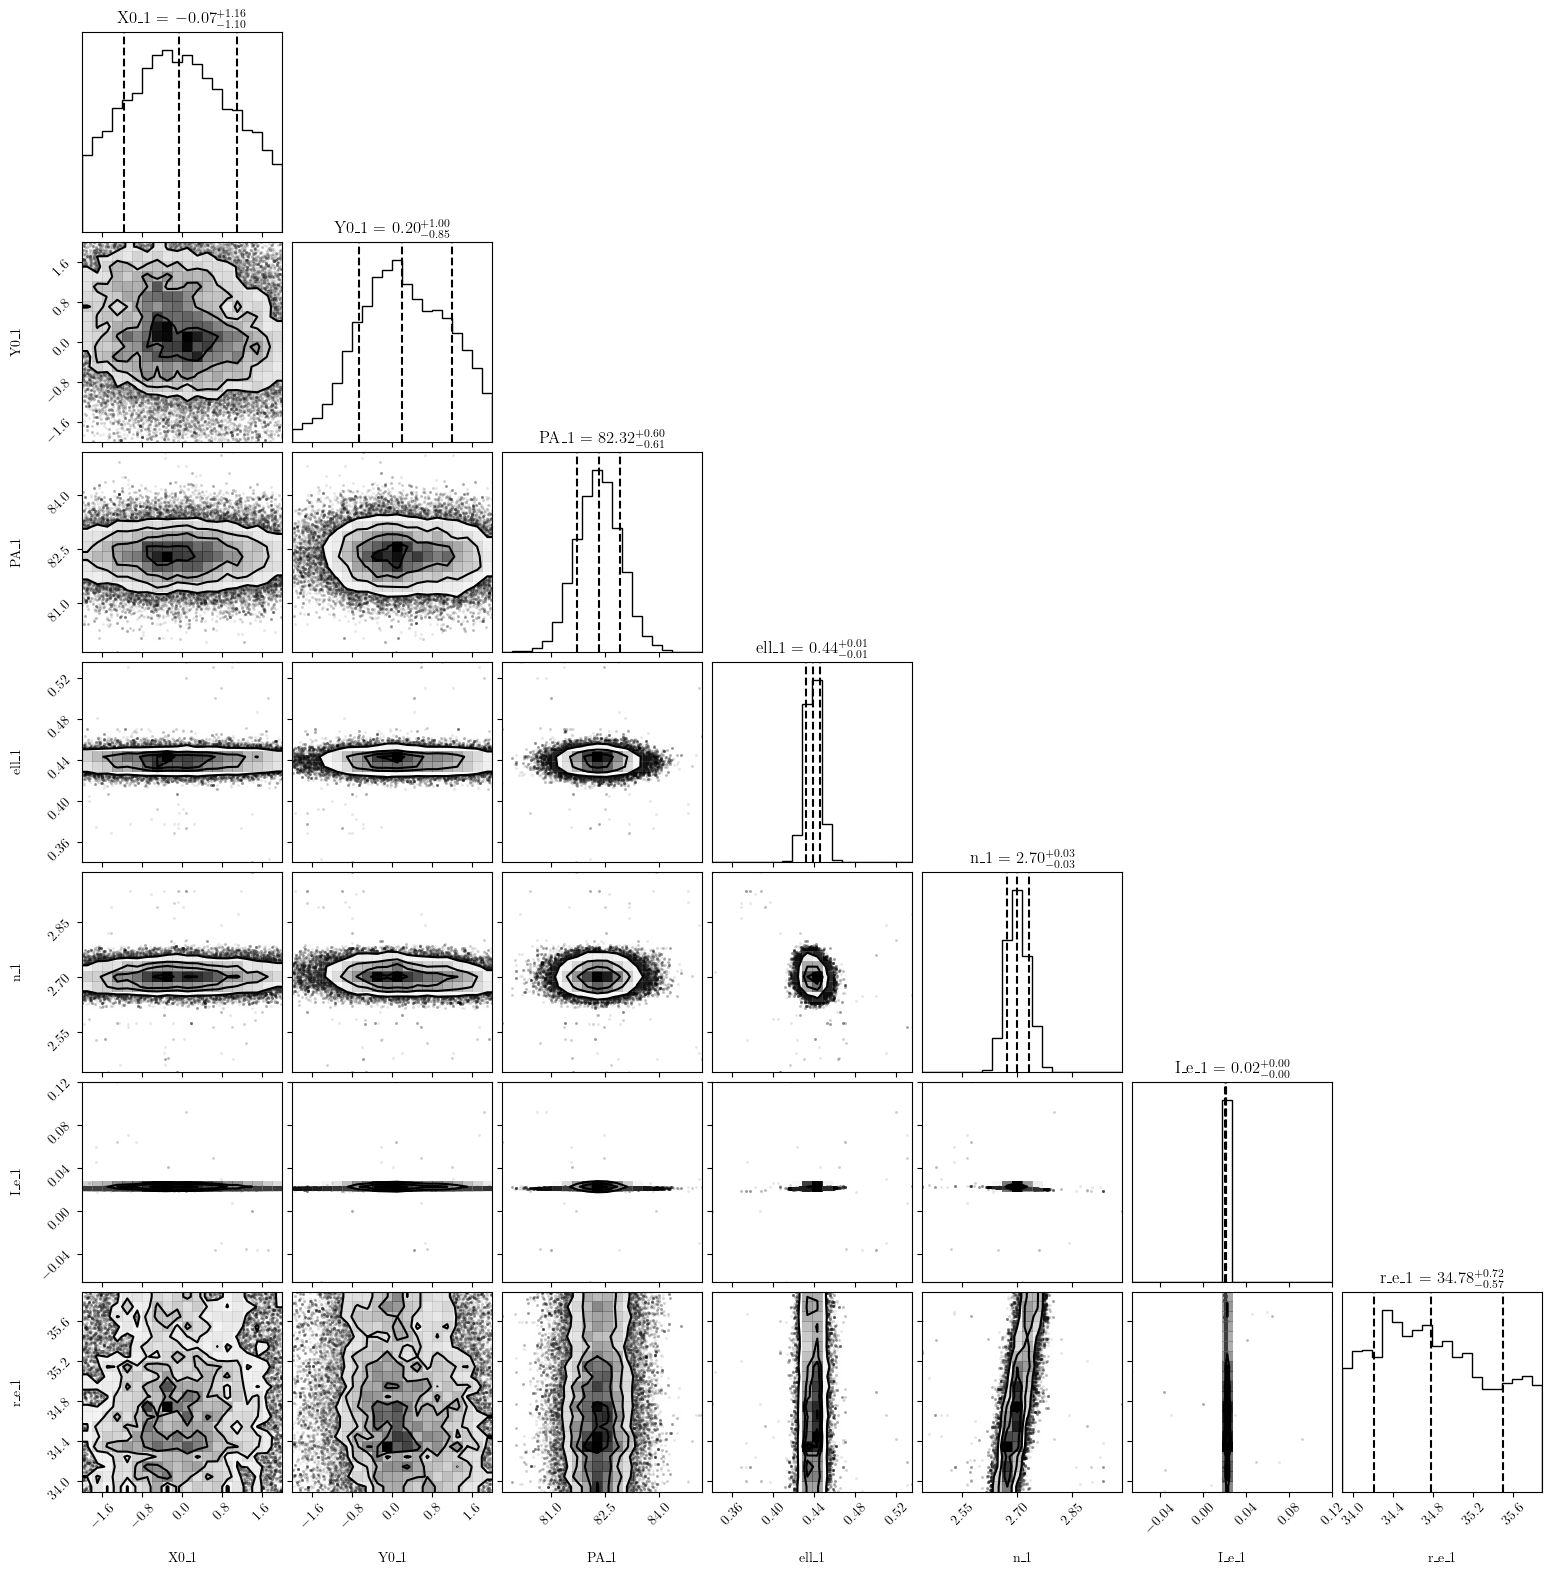

In [31]:
for i in range(len(imgs_x)):
    imfit_Bestfit_Path = folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt'
    imfit_Bestfit = pd.read_csv(imfit_Bestfit_Path,comment='#',header=None,sep='\t')
    bestfit_X0 = imfit_Bestfit[2][0]
    bestfit_Y0 = imfit_Bestfit[2][1]
    
    file_name = 'mcmc_result_img_'+str(i+1)+'_chain' # imfit output chain's file name
    mcmc_path = folder4imfitfiles+'/imfit_ImgPos/' # path to the folder containing the mcmc chain files
    Combine_MCMC_Chain(file_name,mcmc_path)
    data = pd.read_csv(mcmc_path+file_name+'.txt',sep='\s+')
    accpetance_rate = (data[data['accept']==1]).shape[0]/data.shape[0] * 100
    print('accpetance rate = '+ str(np.round(accpetance_rate,2)) + '%')
    data = data[data['accept']==1]
    data = data.drop(columns=['likelihood','burn-in','CR1','CR2','CR3','accept'])
    data['X0_1'] = (data['X0_1']-bestfit_X0)*0.04*1000
    data['Y0_1'] = (data['Y0_1']-bestfit_Y0)*0.04*1000
    data.to_numpy()
    # Plot it.
    figure = corner.corner(
        data,
        quantiles=[0.16, 0.5, 0.84],
        labels=list(data),
        show_titles=True,
        #title_kwargs={"fontsize": 16},
    )

In [32]:
# Extract the best fit parameters

file_name = 'mcmc_result_img_'+str(i+1)+'_chain' # imfit output chain's file name
mcmc_path = folder4imfitfiles+'/imfit_ImgPos/' # path to the folder containing the mcmc chain files
Combine_MCMC_Chain(file_name,mcmc_path)
data = pd.read_csv(mcmc_path+file_name+'.txt',sep='\s+')
accpetance_rate = (data[data['accept']==1]).shape[0]/data.shape[0] * 100
print('accpetance rate = '+ str(np.round(accpetance_rate,2)) + '%')
data = data[data['accept']==1]

bestfit_X0 = data['X0_1'].mean()
bestfit_Y0 = data['Y0_1'].mean()
bestfit_PA = data['PA_1'].mean()
bestfit_ell = data['ell_1'].mean()
bestfit_n = data['n_1'].mean()
bestfit_I_e = data['I_e_1'].mean()
bestfit_r_e = data['r_e_1'].mean()

print('X0 = ' + str(bestfit_X0))
print('Y0 = ' + str(bestfit_Y0))
print('PA = ' + str(bestfit_PA))
print('ell = ' + str(bestfit_ell))
print('n = ' + str(bestfit_n))
print('I_e = ' + str(bestfit_I_e))
print('r_e = ' + str(bestfit_r_e))

accpetance rate = 12.26%
X0 = 521.5020066460609
Y0 = 520.7155158670806
PA = 82.3154178436688
ell = 0.4391639442168926
n = 2.70183199345228
I_e = 0.021145639374528753
r_e = 34.82777166027271


In [33]:
def write_imfit_gal_config_str(img_x , img_y , image):
    string = ''
    string += 'X0' + '\t' + str(bestfit_X0) + '\n'
    string += 'Y0' + '\t' + str(bestfit_Y0) + '\n'
    string += 'FUNCTION Sersic' + '\n'
    string += 'PA' + '\t' + str(bestfit_PA) + '\n'
    string += 'ell' + '\t' + str(bestfit_ell) + '\n'
    string += 'n' + '\t' + str(bestfit_n) + '\n' # Sersic index
    string += 'I_e' + '\t' + str(bestfit_I_e) + ' \n' # Surface brightness at the effective radius
    string += 'r_e' + '\t' + str(bestfit_r_e) + ' \n' # Effective radius
    return string

In [35]:
def get_Pos_1stGuess(mock_lens_data):
    image = mock_lens_data

    # Apply Gaussian Filter to Denoise
    smoothed_image = image # No smoothing this time #ndimage.gaussian_filter(image, sigma=2)

    # Find Local Maxima
    threshold = np.std(image)*10  # 5 sig above noise
    local_max = (smoothed_image == ndimage.maximum_filter(smoothed_image, size=5)) & (smoothed_image > threshold)

    # Get Peak Coordinates
    peaks = np.argwhere(local_max)
    imgs_x , imgs_y = peaks[:, 1], peaks[:, 0]
    imgs_x , imgs_y = np.asarray(imgs_x) , np.asarray(imgs_y)
    imgs_x , imgs_y = imgs_x+1 , imgs_y+1
    return imgs_x , imgs_y

# Approximate centre of the galaxy
imgs_x , imgs_y = get_Pos_1stGuess(gal)
print(imgs_x , imgs_y)

# def write_imfit_gal_config_str(img_x , img_y , image):
#     string = ''
#     string += 'X0' + '\t' + str(521.3414) + '\n'
#     string += 'Y0' + '\t' + str(520.8546) + '\n'
#     string += 'FUNCTION Sersic' + '\n'
#     string += 'PA' + '\t' + str(82.4567) + '\n'
#     string += 'ell' + '\t' + str(0.708713) + '\n'
#     string += 'n' + '\t' + str(1.0) + '\n' # Sersic index
#     string += 'I_e' + '\t' + str(0.1) + ' \n' # Surface brightness at the effective radius
#     string += 'r_e' + '\t' + str(11.74229) + ' \n' # Effective radius
#     return string


[522] [521]


In [36]:
# Run imfit 
for i in range(len(imgs_x)):
    # Create and save the masking map
    mask = create_mask_circle(imgs_x[i],imgs_y[i],mock_lens_data,Radius=20)
    saveFITS_simple(np.int8(mask),folder4imfitfiles+'/imfit_ImgPos/','mask_img_'+str(i+1))
    # Create and save the config file
    text = write_imfit_gal_config_str(imgs_x[i] , imgs_y[i] , mock_lens_data)
    config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'gal_config_img_'+str(i+1)+'.txt'
    save_imfit_config(text,config_output_FilePath)
    # Print the command for running imfit
    imfit_cmd = (imfit_PATH+'./makeimage ' + config_output_FilePath + ' --ncols 1039 --nrows 1039')
    os.system(imfit_cmd)

* No PSF image supplied -- no image convolution will be done!
Function: Sersic
Model Object: 1079521 data values (pixels)
7 total parameters

Saving output model image ("modelimage.fits") ...
Done!



(487.3821825337473, 554.048849200414)

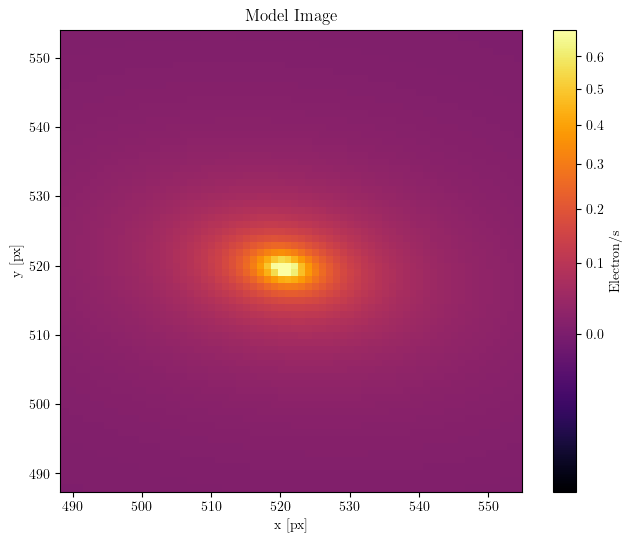

In [37]:
# Plot makeimage output
makeimage = fits.open('modelimage.fits')[0].data

imgs_x = bestfit_X0
imgs_y = bestfit_Y0

zoom_factor = 0.03 # (Between 1 and 0 to zoom in and out)
zoom = 1/zoom_factor

plt.figure(figsize=(8,6))
plt.imshow(makeimage, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Model Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)


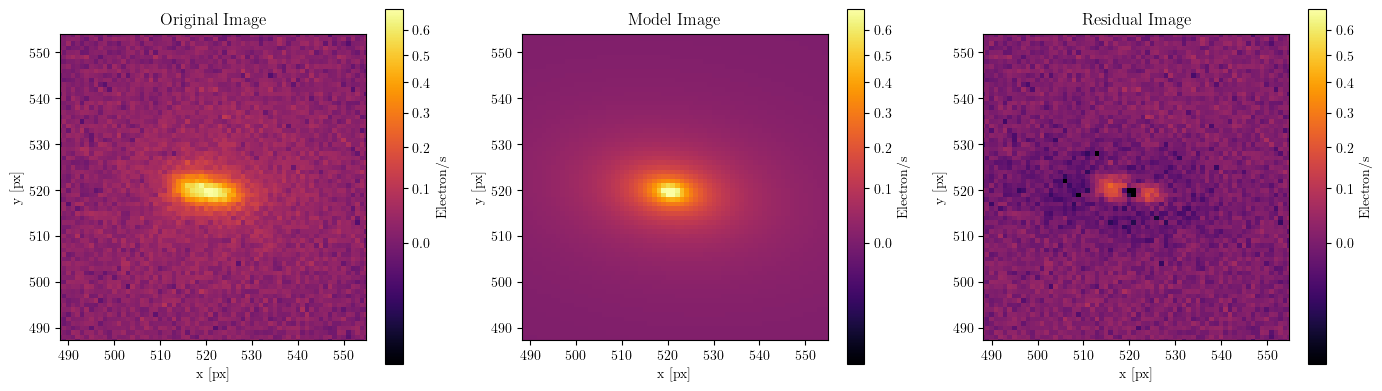

In [38]:
# Side by side comparison
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(gal, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)

plt.subplot(1,3,2)
plt.imshow(makeimage, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Model Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)

plt.subplot(1,3,3)
plt.imshow(gal-makeimage, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Residual Image')
plt.colorbar(label='Electron/s')
plt.xlim(imgs_x - zoom, imgs_x + zoom)
plt.ylim(imgs_y - zoom, imgs_y + zoom)

plt.tight_layout()

In [26]:

ell_range = np.linspace(0.1, 1.0, 10)
n_range = np.linspace(0.1, 5.0, 10)
ie_range = np.linspace(0.1, 2.0, 10)
re_range = np.linspace(0.1, 20, 10)

results = []

for ell in ell_range:
    for n in n_range:
        for ie in ie_range:
            for re in re_range:

                config_str = f"""
                X0\t{bestfit_X0}
                Y0\t{bestfit_Y0}
                FUNCTION Sersic
                PA\t{bestfit_PA}
                ell\t{ell}
                n\t{n}
                I_e\t{ie}
                r_e\t{re}
                """
                
                config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'grid_config.txt'
                save_imfit_config(config_str, config_output_FilePath)
                
                imfit_cmd = (imfit_PATH+'./makeimage ' + config_output_FilePath + ' --ncols 1039 --nrows 1039')
                os.system(imfit_cmd)
                
                makeimage = fits.open('modelimage.fits')[0].data
                
                residuals = gal - makeimage
                residual_sum = np.sum(np.abs(residuals))
                
                results.append({
                    'ell': ell,
                    'n': n,
                    'I_e': ie,
                    'r_e': re,
                    'residual_sum': residual_sum
                })


results_df = pd.DataFrame(results)
print(results_df)


* No PSF image supplied -- no image convolution will be done!
Function: Sersic
Model Object: 1079521 data values (pixels)
7 total parameters

Saving output model image ("modelimage.fits") ...
Done!

* No PSF image supplied -- no image convolution will be done!
Function: Sersic
Model Object: 1079521 data values (pixels)
7 total parameters

Saving output model image ("modelimage.fits") ...
Done!

* No PSF image supplied -- no image convolution will be done!
Function: Sersic
Model Object: 1079521 data values (pixels)
7 total parameters

Saving output model image ("modelimage.fits") ...
Done!

* No PSF image supplied -- no image convolution will be done!
Function: Sersic
Model Object: 1079521 data values (pixels)
7 total parameters

Saving output model image ("modelimage.fits") ...
Done!

* No PSF image supplied -- no image convolution will be done!
Function: Sersic
Model Object: 1079521 data values (pixels)
7 total parameters

Saving output model image ("modelimage.fits") ...
Done!

* No 

: 

: 

In [50]:
print('Best fit parameters:')
print(results_df.loc[results_df['residual_sum'].idxmin()])
print('###################################################')
print('###################################################')


Best fit parameters:
ell                 0.500000
n                   1.733333
I_e                 0.100000
r_e                13.366667
residual_sum    17094.992551
Name: 4306, dtype: float64
###################################################
###################################################


* No PSF image supplied -- no image convolution will be done!
Function: Sersic
Model Object: 1079521 data values (pixels)
7 total parameters

Saving output model image ("modelimage.fits") ...
Done!



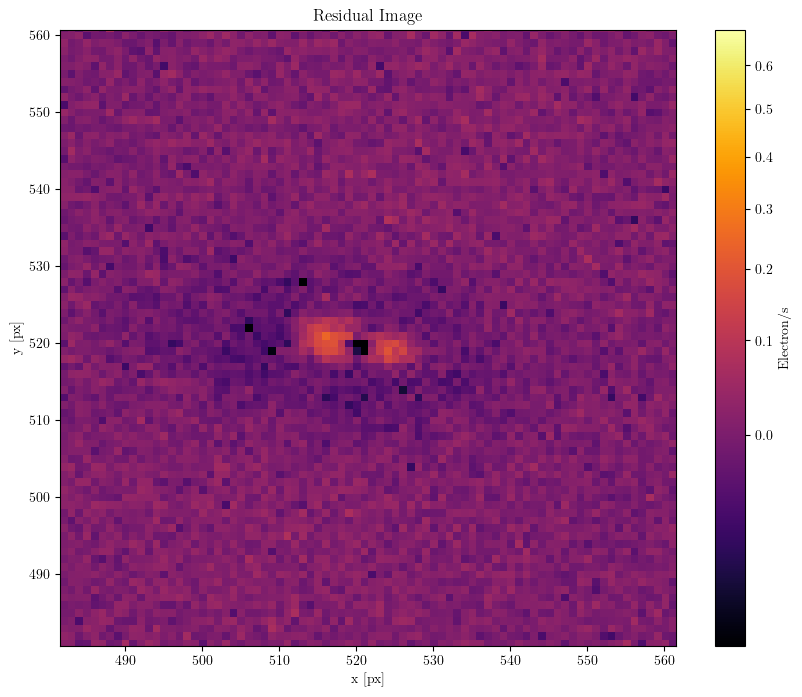

In [34]:

config_str = f"""
X0\t{bestfit_X0}
Y0\t{bestfit_Y0}
FUNCTION Sersic
PA\t{bestfit_PA}
ell\t{bestfit_ell}
n\t{bestfit_n}
I_e\t{bestfit_I_e}
r_e\t{bestfit_r_e}
"""

config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'bestfit_config.txt'
save_imfit_config(config_str, config_output_FilePath)

imfit_cmd = (imfit_PATH+'./makeimage ' + config_output_FilePath + ' --ncols 1039 --nrows 1039')
os.system(imfit_cmd)

makeimage = fits.open('modelimage.fits')[0].data

residuals = gal - makeimage

plt.figure(figsize=(10,8))
plt.imshow(residuals, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Residual Image')
plt.colorbar(label='Electron/s')
plt.xlim(bestfit_X0 - zoom, bestfit_X0 + zoom)
plt.ylim(bestfit_Y0 - zoom, bestfit_Y0 + zoom)
plt.show()